# Network of sensors - Feature Selection

## Use case specifications

### Goal

The final objective is to determine the concentration of a pollutant for a given station at a given timestamp (date and time). 11 pollution stations have been selected in Montreal, as well as 1 weather station.

### Inputs available

For this, the available inputs are:
- the GPS positions of the different stations (with meteorological and pollution sensors)
- sensor inputs for each station, with their timestamp ([Meteo data source](https://climat.meteo.gc.ca) and [Pollution data source](https://donnees.montreal.ca/ville-de-montreal/rsqa-polluants-gazeux))
- map data of the city

### Feature selection

The `feature selection` part is essential to avoid an excess of data used by the Machine Learning model which could reduce the quality of prediction.

It is important to note that we work with spatio-temporal type data.

The feature selection will be split into 2 layers: `metadata` and `data`.

### Metadata

Metadata gives the overall context of the data. They allow to perform a pre-processing on them if necessary before making the feature selection.

The question is to know which metadata are necessary and especially how to exploit them. Here is a non-exhaustive list of metadata that may be needed as inputs to perform feature selection correctly.

- GPS positions of the sensors
    - Calculation of distances between sensors: *How to include it later in the feature selection data or model?*
- Seasonality
    - Use of feature selection models taking into account the seasonality aspect
    - Data preprocessing: `new_value[t] = value[t] - value[t - 1 * seasonality]`
- Cartography
    - Topology
        - Influence on distance calculation
    - City infrastructure (housing, factories, streets, etc.)
        - Calculation of `weight` of the sensors
        - Influence on distance calculation
- Meteorology
    - Data pre-processing: *Should the weather sensors be considered as metadata used to transform the data or just be included in the data?* In the case of the use of pollution, one can imagine that physics makes it There is a time lag between two sensors also related to wind speed and direction.

In [1]:
# Importation of librairies

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from libs.utils_pollution import *
from libs.utils_meteorological import *
from libs.utils_data import *
from libs.utils_spatial import *

from libs.sts_featureselection import *

/usr/local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Data preparation

In [2]:
# Export all useful constants

# borough_geojson_file = "https://data.montreal.ca/dataset/b628f1da-9dc3-4bb1-9875-1470f891afb1/resource/92cb062a-11be-4222-9ea5-867e7e64c5ff/download/limites-terrestres.geojson"
borough_geojson_file = "./data/limites-terrestres.geojson"

# csv_stations_references = "https://data.montreal.ca/dataset/ae01f7f3-4d69-404a-9be1-74abfdc96571/resource/29db5545-89a4-4e4a-9e95-05aa6dc2fd80/download/liste-des-stations-rsqa.csv"
csv_stations_references = "./data/liste-des-stations-rsqa.csv"

# csv_all_pollutants = "https://data.montreal.ca/dataset/a2eea289-f9b1-4e51-a6fc-3299aa8f2ba7/resource/811e76d0-90cb-4703-bd6f-bd0faff81f4a/download/rsqa-multi-polluants2020.csv"
csv_all_pollutants = "./data/rsqa-multi-polluants2020.csv"

meteorological_stations_ids = [51157, 49608, 30165, 48374]
csv_meteo_api = "https://climat.meteo.gc.ca/climate_data/bulk_data_f.html?format=csv&stationID={STATIONID}&Year={YEAR}&Month={MONTH}&Day={DAY}&time=UTC&timeframe=1&submit=T%C3%A9l%C3%A9charger%20des%20donn%C3%A9es"

### Visualization of pollution stations

In [3]:
stations_references = pd.read_csv(csv_stations_references)

<Figure size 1440x1440 with 0 Axes>

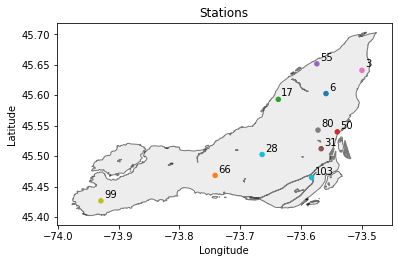

In [4]:
visualise_stations(stations_references[stations_references.statut == 'ouvert'], borough_geojson_file)

### Import pollution data

In [5]:
pollution_data = pd.read_csv(csv_all_pollutants)
pollution_data.head()

,numero_station,date_heure,co,no,no2,pm2_5,pst,pm10,o3,so2,bc1_370nm,bc6_880nm,Benzene,Toluene,Ethylbenzene,M P-Xylene,O-Xylene
0,3,01-01-2020 01:00,N/M,0.121867,8.667018,8.746077,N/M,N/M,15.65643,0,N/M,N/M,5.743625,2.754026,0.355111,6.189929,0.569096
1,3,01-01-2020 02:00,N/M,0.070021,5.937763,5.5934,N/M,N/M,16.69138,0,N/M,N/M,1.40336,1.692388,0.479124,17.34458,0.638791
2,3,01-01-2020 03:00,N/M,0.847384,10.14027,6.916233,N/M,N/M,13.30661,0,N/M,N/M,1.384068,1.533221,0.363582,13.26551,0.476262
3,3,01-01-2020 04:00,N/M,0.343275,6.808739,6.848,N/M,N/M,15.83292,0,N/M,N/M,1.364819,1.456055,0.346235,11.88057,0.420513
4,3,01-01-2020 05:00,N/M,0.085947,4.765573,6.238298,N/M,N/M,17.40574,0,N/M,N/M,0.785679,1.041375,0.248069,9.535387,0.309693


In [6]:
# We transform the datafame to have a column by sensor by station instead of a column for the station ID and the other for the sensor's name
pollution_data = transform_all_pollutants_data(pollution_data)

# We transform unknow key values / non numerical values to na
pollution_data = convert_unknown_values_to_na(pollution_data)

# We remove columns containing only na values
pollution_data = remove_empty_columns(pollution_data)

pollution_data.head()

,no_station_3,no2_station_3,pm2_5_station_3,o3_station_3,so2_station_3,Benzene_station_3,Toluene_station_3,Ethylbenzene_station_3,M P-Xylene_station_3,O-Xylene_station_3,...,no2_station_99,pm2_5_station_99,o3_station_99,so2_station_99,no_station_103,no2_station_103,pm2_5_station_103,pst_station_103,pm10_station_103,o3_station_103
date_heure,,,,,,,,,,,,,,,,,,,,,
2020-01-01 01:00:00,0.121867,8.667018,8.746077,15.65643,0.0,5.743625,2.754026,0.355111,6.189929,0.569096,...,3.248914,2.837178,20.53666,0.0,0.000000,4.582468,4.249444,5.496387,5.493054,18.90542
2020-01-01 02:00:00,0.070021,5.937763,5.593400,16.69138,0.0,1.403360,1.692388,0.479124,17.344580,0.638791,...,3.324254,3.145111,20.52980,0.0,0.000000,4.323431,5.813416,8.411389,8.065554,18.67736
2020-01-01 03:00:00,0.847384,10.140270,6.916233,13.30661,0.0,1.384068,1.533221,0.363582,13.265510,0.476262,...,3.744425,3.346333,19.87264,0.0,0.076251,4.195025,5.367332,8.120139,7.684998,18.52408
2020-01-01 04:00:00,0.343275,6.808739,6.848000,15.83292,0.0,1.364819,1.456055,0.346235,11.880570,0.420513,...,3.026699,3.581054,21.03147,0.0,0.000000,4.036451,4.810264,6.188667,6.111941,18.76897
2020-01-01 05:00:00,0.085947,4.765573,6.238298,17.40574,0.0,0.785679,1.041375,0.248069,9.535387,0.309693,...,1.800147,3.109388,21.96484,0.0,0.000000,3.402587,4.696846,7.290452,6.689124,19.69922


In [7]:
pollution_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2020-01-01 01:00:00 to 2021-01-01 00:00:00
Data columns (total 64 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   no_station_3            8662 non-null   float64
 1   no2_station_3           8662 non-null   float64
 2   pm2_5_station_3         8716 non-null   float64
 3   o3_station_3            8578 non-null   float64
 4   so2_station_3           8752 non-null   float64
 5   Benzene_station_3       8487 non-null   float64
 6   Toluene_station_3       8487 non-null   float64
 7   Ethylbenzene_station_3  8487 non-null   float64
 8   M P-Xylene_station_3    8487 non-null   float64
 9   O-Xylene_station_3      8487 non-null   float64
 10  no_station_6            8459 non-null   float64
 11  no2_station_6           8459 non-null   float64
 12  pm2_5_station_6         8173 non-null   float64
 13  o3_station_6            8295 non-null   float64
 14  so2_

### Importing weather data

In [8]:
use_local_file = True

if(use_local_file==True): # loading the local csv file
    meteorological_data = pd.read_csv('./data/meteorological_data.csv')
    meteorological_data['Date/Heure (UTC)'] = pd.to_datetime(meteorological_data['Date/Heure (UTC)'], format='%Y-%m-%d %H:%M')
    meteorological_data = meteorological_data.set_index('Date/Heure (UTC)')
else: # loading meteorological data from the api
    # Save datetime indexes as a variable
    datetime_indexes = pollution_data.index.values
    
    # Load the meteorological for the datetime indexes
    meteorological_data = load_meteorological_data(datetime_indexes, csv_meteo_api, meteorological_stations_ids)

meteorological_data.head()

,Longitude (x),Latitude (y),Nom de la Station,ID climatologique,Année,Mois,Jour,Heure (UTC),Temp (°C),Temp Indicateur,...,Vit. du vent Indicateur,Visibilité (km),Visibilité Indicateur,Pression à la station (kPa),Pression à la station Indicateur,Hmdx,Hmdx Indicateur,Refroid. éolien,Refroid. éolien Indicateur,Temps
Date/Heure (UTC),,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,"-73,74","45,47",MONTREAL INTL A,7025251,2020,1,1,00:00,"0,5",NaN,...,NaN,"2,4",NaN,"99,44",NaN,NaN,NaN,NaN,NaN,Neige
2020-01-01 01:00:00,"-73,74","45,47",MONTREAL INTL A,7025251,2020,1,1,01:00,"0,6",NaN,...,NaN,"4,0",NaN,"99,41",NaN,NaN,NaN,NaN,NaN,Neige
2020-01-01 02:00:00,"-73,74","45,47",MONTREAL INTL A,7025251,2020,1,1,02:00,"0,5",NaN,...,NaN,"24,1",NaN,"99,38",NaN,NaN,NaN,NaN,NaN,Neige
2020-01-01 03:00:00,"-73,74","45,47",MONTREAL INTL A,7025251,2020,1,1,03:00,"0,5",NaN,...,NaN,"12,9",NaN,"99,38",NaN,NaN,NaN,NaN,NaN,Neige
2020-01-01 04:00:00,"-73,74","45,47",MONTREAL INTL A,7025251,2020,1,1,04:00,"0,3",NaN,...,NaN,"9,7",NaN,"99,35",NaN,NaN,NaN,NaN,NaN,Neige


In [9]:

# We remove the columns containing only na values
meteorological_data = remove_empty_columns(meteorological_data)

# We remove the columns that we dont want to use
meteorological_data = remove_unused_columns(meteorological_data)

# We convert the columns to the float type
meteorological_data = convert_columns_to_float_type(meteorological_data)

meteorological_data.head()

,Temp (°C),Point de rosée (°C),Hum. rel (%),Dir. du vent (10s deg),Vit. du vent (km/h),Visibilité (km),Pression à la station (kPa),Hmdx,Refroid. éolien
Date/Heure (UTC),,,,,,,,,
2020-01-01 00:00:00,0.5,-0.3,94.0,9.0,5.0,2.4,99.44,NaN,NaN
2020-01-01 01:00:00,0.6,0.0,96.0,16.0,13.0,4.0,99.41,NaN,NaN
2020-01-01 02:00:00,0.5,-0.3,95.0,24.0,19.0,24.1,99.38,NaN,NaN
2020-01-01 03:00:00,0.5,-1.0,90.0,25.0,19.0,12.9,99.38,NaN,NaN
2020-01-01 04:00:00,0.3,-1.2,90.0,24.0,20.0,9.7,99.35,NaN,NaN


In [10]:
meteorological_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9528 entries, 2020-01-01 00:00:00 to 2021-01-31 23:00:00
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Temp (°C)                    9526 non-null   float64
 1   Point de rosée (°C)          9527 non-null   float64
 2   Hum. rel (%)                 9527 non-null   float64
 3   Dir. du vent (10s deg)       9520 non-null   float64
 4   Vit. du vent (km/h)          9527 non-null   float64
 5   Visibilité (km)              9527 non-null   float64
 6   Pression à la station (kPa)  9527 non-null   float64
 7   Hmdx                         1540 non-null   float64
 8   Refroid. éolien              2849 non-null   float64
dtypes: float64(9)
memory usage: 744.4 KB


### Concatenation of pollution and weather data

In [11]:
data = pd.concat([pollution_data, meteorological_data], axis=1, join='outer')
#data = shift_data(data, 2)
data.head(3)

,no_station_3,no2_station_3,pm2_5_station_3,o3_station_3,so2_station_3,Benzene_station_3,Toluene_station_3,Ethylbenzene_station_3,M P-Xylene_station_3,O-Xylene_station_3,...,o3_station_103,Temp (°C),Point de rosée (°C),Hum. rel (%),Dir. du vent (10s deg),Vit. du vent (km/h),Visibilité (km),Pression à la station (kPa),Hmdx,Refroid. éolien
2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.5,-0.3,94.0,9.0,5.0,2.4,99.44,NaN,NaN
2020-01-01 01:00:00,0.121867,8.667018,8.746077,15.65643,0.0,5.743625,2.754026,0.355111,6.189929,0.569096,...,18.90542,0.6,0.0,96.0,16.0,13.0,4.0,99.41,NaN,NaN
2020-01-01 02:00:00,0.070021,5.937763,5.593400,16.69138,0.0,1.403360,1.692388,0.479124,17.344580,0.638791,...,18.67736,0.5,-0.3,95.0,24.0,19.0,24.1,99.38,NaN,NaN


### Management of missing values

>>> Missing value visualization:


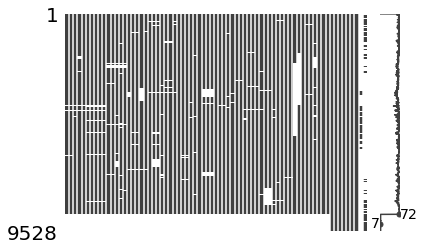

In [12]:
inspect_data(df = data)

>>> Missing value visualization:


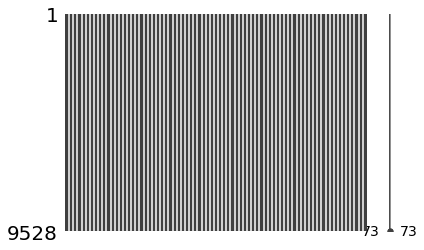

In [13]:
data = data.fillna(method='ffill')
data = data.fillna(method='bfill')
inspect_data(df = data)

In [14]:
# As the RFE algorithm is time-consuming, we remove the most correlated features to reduce the loading time
correlated_features = set()
correlation_matrix = data.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

data_light = data.drop(correlated_features, axis=1)

## Feature Selection

The main goal of this notebook is to explore the various feature selection techniques and compare them in order to retain the best ones. But first, let's define clearly what is the feature selection.


### What is feature selection?

Feature selection is a dimensionnality reduction techniques aiming to choose a small subset of the relevant features from the original features by removing irrelevant, redundant, or noisy features. Feature selection usually can lead to better learning performance, higher learning accuracy, lower computational cost, and better model interpretability.

Feature selection occurs as a data preprocessing step in the ML pipeline. It has been proven to be effective and efficient in preparing high-dimensional data for machine learning and pattern recognition problems.

![Image of Danny Butvinik](https://miro.medium.com/max/888/1*vJdhKDHgLLV7el7Vm4PuEQ.jpeg)


### Which techniques?

Feature selection techniques can be roughly summarized in 3 categories: Filter, wrapper and embedded methods.

*   ***Filter methods***: features are selected based on statistical measures. It is independent of the learning algorithm and requires less computational time. Among existing techniques: chi-2, pearson correlation, missing value ratio..
*   ***Wrapper methods***: in wrapper methods a predictive model is used to evaluate a combination of features and assign model performance scores. The performance of the Wrapper method depends on the classifier. The best subset of features is selected based on the results of the classifier. Wrapper methods are computationally more expensive than filter methods, due to the repeated learning steps and cross-validation. However, these methods are more accurate than the filter method. Some of the examples are Recursive feature elimination, Sequential feature selection algorithms, and Genetic algorithms.
*   ***Embedded methods***: in embedded methods, there are ensemble learning and hybrid learning methods for feature selection. Since it has a collective decision, its performance is better than the other two models. Random forest is one such example. It is computationally less intensive than wrapper methods. However, this method has a drawback specific to a learning model.
In embedded techniques, the feature selection algorithm is integrated as part of the learning algorithm. The most typical embedded technique is the decision tree algorithm. Decision tree algorithms select a feature in each recursive step of the tree growth process and divide the sample set into smaller subset

![Image of Danny Butvinik](https://miro.medium.com/max/1400/1*9h2qPmOJonbCdthfeVkuyg.jpeg)



#### To test the outputs of certain feature selection techniques, we will define two different targets representing the pollutants measured by the sensors. By default, we will take PM 2.5 and station NO 3.

In [15]:
# We define our targets, here by default PM 2.5 and NO of station 3
target_1 = 'pm2_5_station_3'
target_2 = 'no_station_3'

# We define the number of features to select
n_features = 15

In [25]:
#Working on a small subset of the data as the algorithms are time-consuming
#We consider here only 3months
df = data_light["01-2020":"01-2020"]

X_1 = df.drop(target_1, axis=1)
y_1 = df[target_1]

X_2 = df.drop(target_2, axis=1)
y_2 = df[target_2]

### **Pearson Correlation (Filter method)**

A statistic that measures the linear correlation between two variables, both of which are continuous. It varies from -1 to +1, where
+1 corresponds to a positive linear correlation, 0 to no linear correlation, and -1 to a negative linear correlation.

In [26]:
# Calcul du coefficient de pearson
target_correlation_1 = df.corr()[[target_1]]
target_correlation_2 = df.corr()[[target_2]]

In [27]:
features_1 = list(abs(target_correlation_1).sort_values(by=target_1, ascending=False)[:n_features].index)
features_2 = list(abs(target_correlation_2).sort_values(by=target_2, ascending=False)[:n_features].index)

Thanks to this method we can decide to keep only the features most correlated with our target.

<AxesSubplot:>

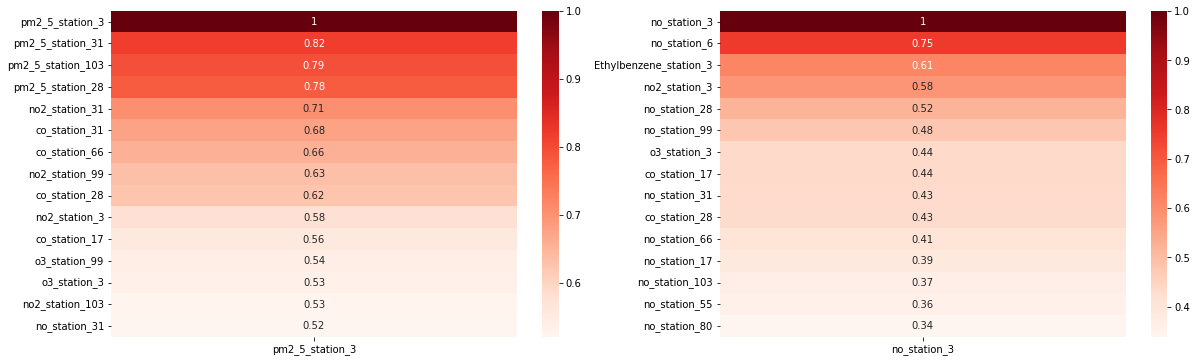

<Figure size 1728x1728 with 0 Axes>

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
fig = plt.figure(figsize=(24,24))
fig.suptitle('Most correlated features with targets PM2.5 and NO')

# We visualize on a heatmap the correlations with the target

# We visualize it on the features most correlated with the target
sns.heatmap(abs(target_correlation_1.loc[features_1]), annot=True, cmap=plt.cm.Reds, ax=ax1)
sns.heatmap(abs(target_correlation_2.loc[features_2]), annot=True, cmap=plt.cm.Reds, ax=ax2)

Among the features most correlated with our target, we should keep only those that are not strongly correlated with each other (otherwise we are on a redundancy of information). This step should be done before any other feature selection technique.

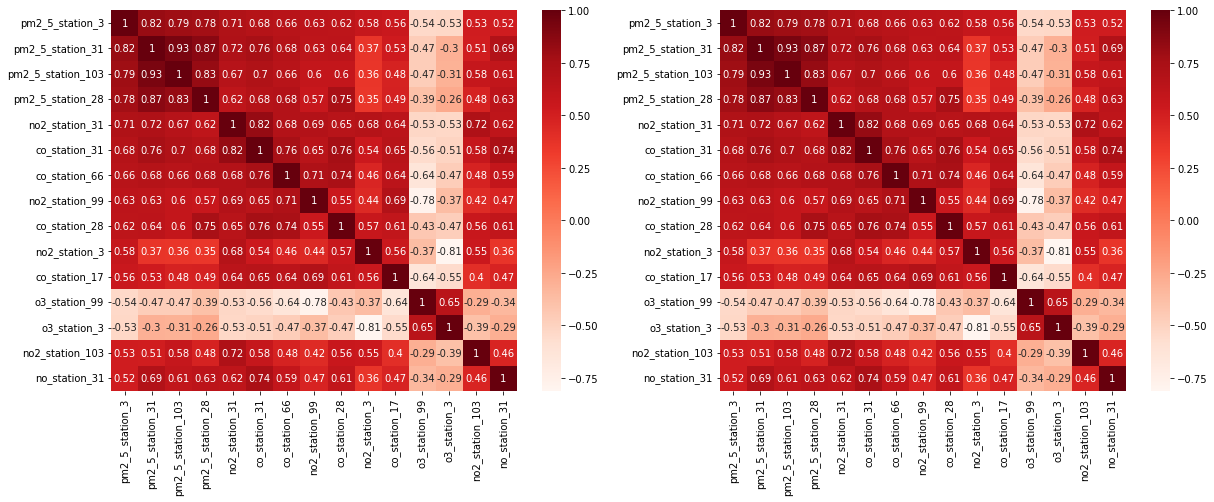

<Figure size 1728x1728 with 0 Axes>

In [29]:
# We look at correlation between chosen features
feature_correlation_1 = df.corr().loc[features_1][features_1]
feature_correlation_2 = df.corr().loc[features_2][features_2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig = plt.figure(figsize=(24,24))
fig.suptitle('Correlation between chosen features')

sns.heatmap(feature_correlation_1, annot=True, cmap=plt.cm.Reds, ax=ax1)
sns.heatmap(feature_correlation_1, annot=True, cmap=plt.cm.Reds, ax=ax2)

plt.show()

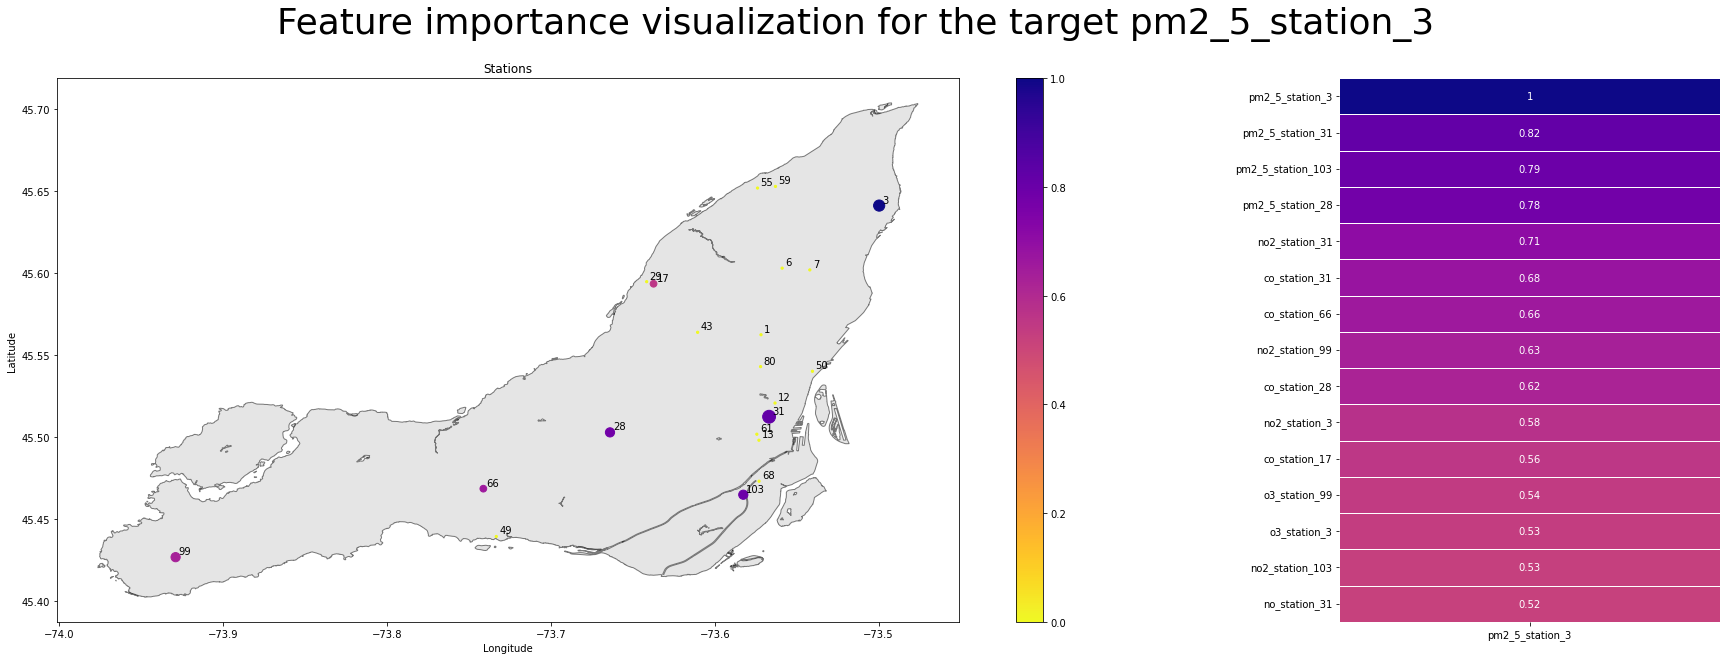

In [31]:
display_feature_importance(abs(target_correlation_1.loc[features_1]), target_1, stations_references, borough_geojson_file)

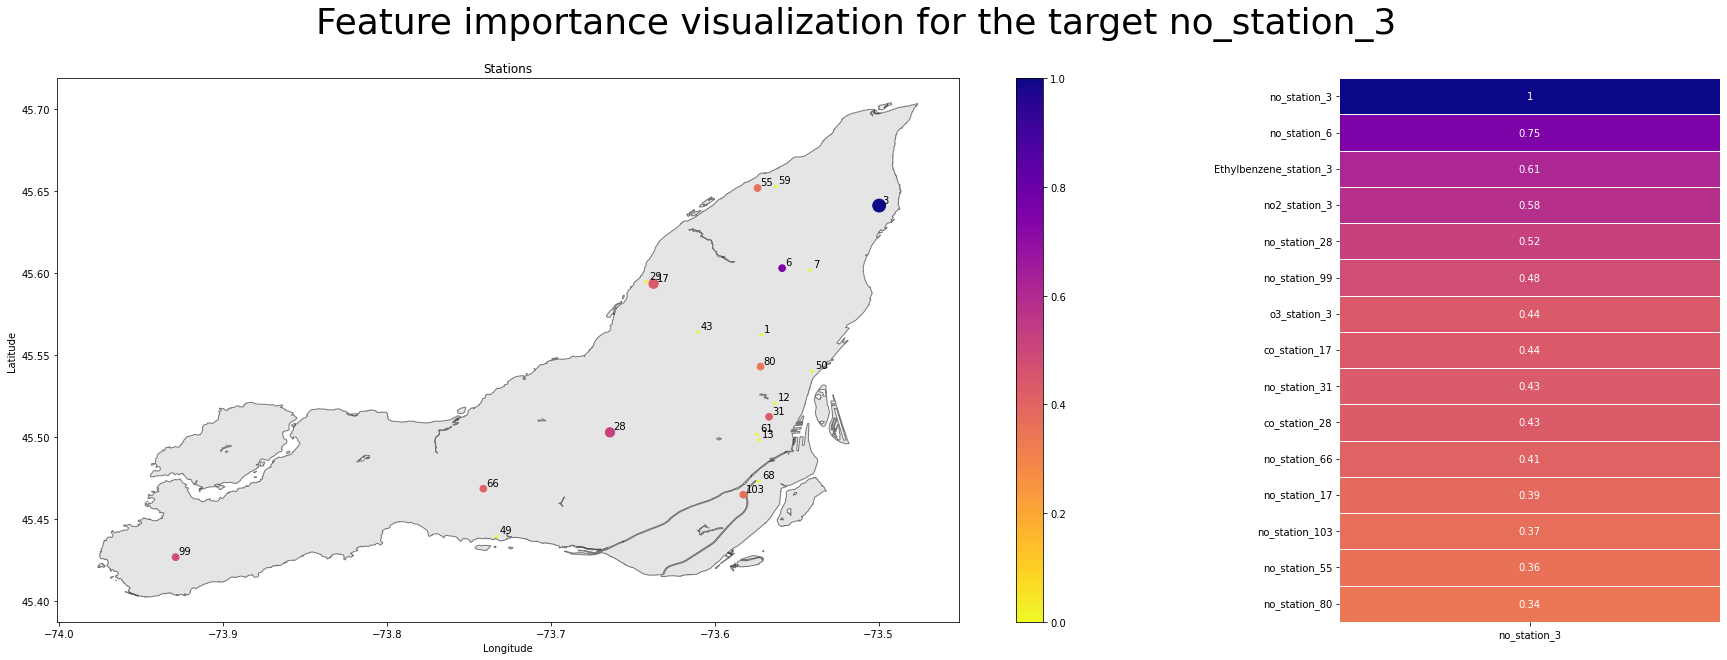

In [30]:
display_feature_importance(abs(target_correlation_2.loc[features_2]), target_2, stations_references, borough_geojson_file)

### **Recursive Feature Elimination (Wrapper method)**

RFE searches for a subset of features starting with all features in the training dataset and dropping features until the desired number remains.

To do this, RFE uses an ML model that is adjusted. Features are listed in order of importance. The less important features are eliminated and the model is readjusted. This process is repeated until a given number of features remain.

Feature selection techniques can be time-consuming. As we have a lot of features (more than 70), we should try removing as much as possible irrelevant features. We can use the Pearson Correlation to remove highly correlated features as they convey the same information, as well as poorly correlated feature with our target.

In [32]:
#We first remove target poorly correlated features and then highly correlated features

#We remove target poorly correlated features
not_corr_1 = abs(target_correlation_1).sort_values(by=target_1)
not_correlated_features_1 = list(not_corr_1[not_corr_1[target_1] < 0.1].index)
not_corr_2 = abs(target_correlation_2).sort_values(by=target_2)
not_correlated_features_2 = list(not_corr_2[not_corr_2[target_2] < 0.1].index)

correlated_features = set()
correlation_matrix = df.corr()

#We remove highly correlated features
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.85:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

drop_features_1, drop_features_2 = correlated_features, correlated_features

drop_features_1.update(not_correlated_features_1)
drop_features_2.update(not_correlated_features_2)

X_1 = X_1.drop(drop_features_1, axis=1)
X_2 = X_2.drop(drop_features_2, axis=1)

Here we use the Random Forests model, a classification algorithm composed of many decision trees, as the basis of our feature selection technique.

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV

rfc = RandomForestRegressor(random_state=101)
rfe_1 = RFECV(estimator=rfc, step=1, verbose=True)
rfe_1.fit(X_1, y_1)

Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features

RFECV(estimator=RandomForestRegressor(random_state=101), verbose=True)

In [47]:
rfe_2 = RFECV(estimator=rfc, step=1, verbose=True)
rfe_2.fit(X_2, y_2)

Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features

RFECV(estimator=RandomForestRegressor(random_state=101), verbose=True)

RFE tell us what is the optimal number of features in the model used to achieve the best regression/classification score (regression in our case)

In [73]:
print('Optimal number of features for target_1: {}'.format(rfe_1.n_features_))
print('Optimal number of features for target_2: {}'.format(rfe_2.n_features_))

Optimal number of features for target_1: 25
Optimal number of features for target_2: 19


In [76]:
# feature_importances_1 = pd.DataFrame({'index': rfe_1.get_feature_names_out(), target_1: rfe_1.estimator.feature_importances_})
# feature_importances_1 = feature_importances_1.set_index('index')
# feature_importances_1 = feature_importances_1.sort_values(by=target_1, ascending=False)
# display_feature_importance(feature_importances_1, target_1, stations_references, borough_geojson_file)
rfe_1.estimator.feature_importances_

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [70]:
rfe_1.get_feature_names_out()

array(['no2_station_3', 'o3_station_3', 'so2_station_3',
       'Benzene_station_3', 'Toluene_station_3', 'Ethylbenzene_station_3',
       'no_station_6', 'co_station_17', 'no_station_17', 'co_station_28',
       'no_station_28', 'pm2_5_station_28', 'co_station_31',
       'no_station_31', 'no2_station_31', 'so2_station_31',
       'pst_station_50', 'no_station_55', 'co_station_66',
       'no_station_66', 'so2_station_80', 'no2_station_99',
       'o3_station_99', 'no_station_103', 'no2_station_103'], dtype=object)

/Users/ismaiilkad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/Users/ismaiilkad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


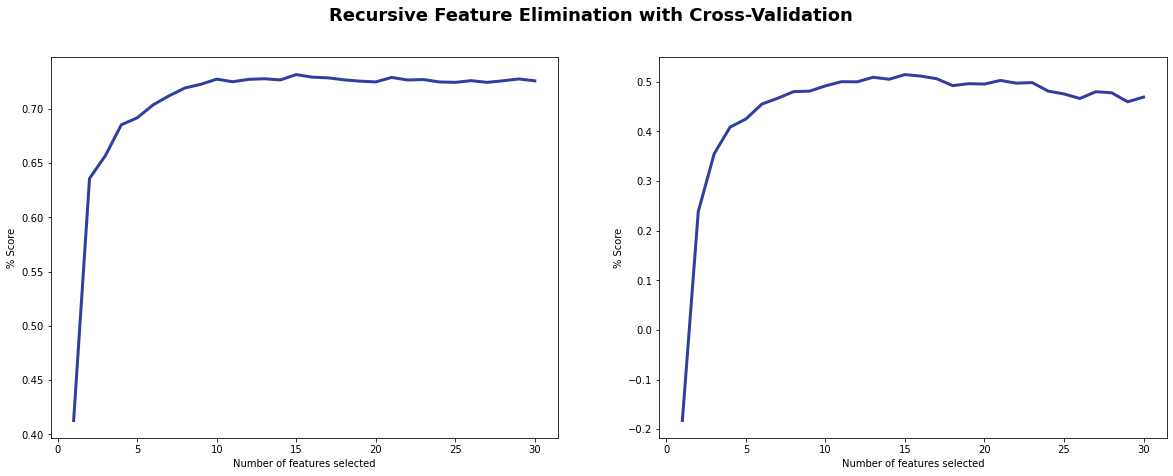

In [134]:
# Display of the score according to the number of features taken into account by the model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold')

ax1.set(xlabel='Number of features selected', ylabel='% Score')
ax2.set(xlabel='Number of features selected', ylabel='% Score')

ax1.plot(range(1, len(rfe_1.grid_scores_) + 1), rfe_1.cv_results_['mean_test_score'], color='#303F9F', linewidth=3)
ax2.plot(range(1, len(rfe_2.grid_scores_) + 1), rfe_2.cv_results_['mean_test_score'], color='#303F9F', linewidth=3)

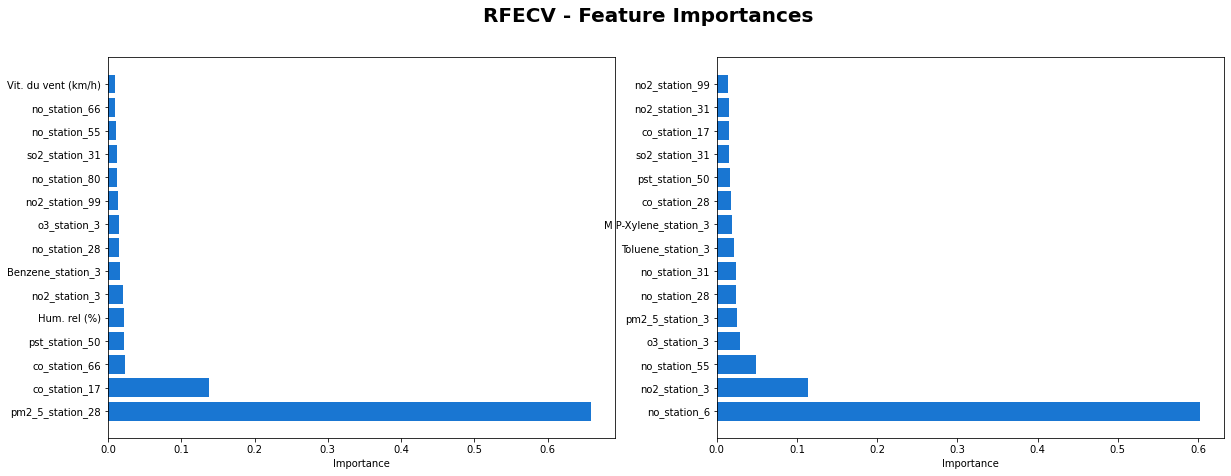

In [135]:
# Display of the importance of all features to predict the target

#Target_1
dset_1 = pd.DataFrame()
dset_1['attr'] = X_1.iloc[:,ind_1].columns
dset_1['importance'] = rfe_1.estimator_.feature_importances_

dset_1 = dset_1.sort_values(by='importance', ascending=False)

#Target_2
dset_2 = pd.DataFrame()
dset_2['attr'] = X_2.iloc[:,ind_2].columns
dset_2['importance'] = rfe_2.estimator_.feature_importances_

dset_2 = dset_2.sort_values(by='importance', ascending=False)

#Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('RFECV - Feature Importances', fontsize=20, fontweight='bold')

ax1.set(xlabel='Importance')
ax2.set(xlabel='Importance')

ax1.barh(y=dset_1['attr'], width=dset_1['importance'], color='#1976D2')
ax2.barh(y=dset_2['attr'], width=dset_2['importance'], color='#1976D2')

plt.show()

### **Boruta (Wrapper method)**

Unlike the RFE technique where features competed with each other for a place in the final subset, in Boruta features competed with a randomized version of themselves (shadow features). A feature is selected only if it performs better than the best performing random feature.

![Image of Manish Pathak](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1520429681/boruta_algo_ft1i8z.png)

The procedure is repeated N times (number of trials) and the final step is to compare the number of times a feature was better than its shadow features using a binomial distribution. When it comes to blue zone features, Boruta's algorithm is undecided,
while features in the green and red zone must be selected and discarded, respectively.

![Image of Samuele Mazzanti](https://miro.medium.com/max/1400/1*yqAUlMtPUiFyr8gYLFagTA.png)



In [136]:
from boruta import BorutaPy

# The model here is the same as for the RFE, i.e a Random Forest model
estimator = RandomForestRegressor()

boruta_1 = BorutaPy(estimator = estimator, n_estimators = 'auto', max_iter = 100, verbose=True)
boruta_1.fit(np.array(X_1), np.array(y_1))

boruta_2 = BorutaPy(estimator = estimator, n_estimators = 'auto', max_iter = 100, verbose=True)
boruta_2.fit(np.array(X_2), np.array(y_2))

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

BorutaPy(estimator=RandomForestRegressor(n_estimators=50,
                                         random_state=RandomState(MT19937) at 0x7FBBE7E04940),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FBBE7E04940, verbose=True)

We can display the features considered important, non-important and those not categorized.

In [137]:
#For target_1

#Features importantes
important = list(X_1.columns[boruta_1.support_])
print(f"Features confirmed as important: {important}")

# Features non catégorisées
tentative = list(X_1.columns[boruta_1.support_weak_])
print(f"Unconfirmed features (tentative): {tentative}")

# Features non importantes
unimportant = list(X_1.columns[~(boruta_1.support_ | boruta_1.support_weak_)])
print(f"Features confirmed as unimportant: {unimportant}")

Features confirmed as important: ['no2_station_3', 'o3_station_3', 'Benzene_station_3', 'no_station_6', 'co_station_17', 'no_station_17', 'co_station_28', 'no_station_28', 'pm2_5_station_28', 'co_station_31', 'no2_station_31', 'so2_station_31', 'pst_station_50', 'no_station_55', 'co_station_66', 'no_station_66', 'no_station_80', 'no2_station_99', 'no2_station_103', 'Hum. rel (%)', 'Vit. du vent (km/h)']
Unconfirmed features (tentative): ['no_station_99']
Features confirmed as unimportant: ['no_station_3', 'Toluene_station_3', 'Ethylbenzene_station_3', 'M P-Xylene_station_3', 'no_station_31', 'o3_station_99', 'no_station_103', 'Hmdx']


In [138]:
#For target_2

#Features importantes
important = list(X_2.columns[boruta_2.support_])
print(f"Features confirmed as important: {important}")

# Features non catégorisées
tentative = list(X_2.columns[boruta_2.support_weak_])
print(f"Unconfirmed features (tentative): {tentative}")

# Features non importantes
unimportant = list(X_2.columns[~(boruta_2.support_ | boruta_2.support_weak_)])
print(f"Features confirmed as unimportant: {unimportant}")

Features confirmed as important: ['no2_station_3', 'pm2_5_station_3', 'o3_station_3', 'Toluene_station_3', 'no_station_6', 'co_station_17', 'no_station_28', 'no_station_31', 'no_station_55']
Unconfirmed features (tentative): ['M P-Xylene_station_3', 'pst_station_50']
Features confirmed as unimportant: ['Benzene_station_3', 'Ethylbenzene_station_3', 'no_station_17', 'co_station_28', 'pm2_5_station_28', 'co_station_31', 'no2_station_31', 'so2_station_31', 'co_station_66', 'no_station_66', 'no_station_80', 'no_station_99', 'no2_station_99', 'o3_station_99', 'no_station_103', 'no2_station_103', 'Hum. rel (%)', 'Vit. du vent (km/h)', 'Hmdx']


### **Boruta SHAP**

Boruta is a robust method for feature selection, but it strongly relies on the calculation of the feature importances, which might be biased or not good enough for the data.
This is where SHAP joins the team. By using SHAP Values as the feature selection method in Boruta, we get the Boruta SHAP Feature Selection Algorithm. With this approach we can get the strong addictive feature explanations existent in SHAP method while having the robustness of Boruta algorithm to ensure only significant variables remain on the set.

#### **SHAP (SHapley Additive exPlanations)** 
SHAP values (SHapley Additive exPlanations) is a method based on cooperative game theory and used to increase transparency and interpretability of machine learning models.
Linear models, for example, can use their coefficients as a metric for the overall importance of each feature, but they are scaled with the scale of the variable itself, which might lead to distortions and misinterpretations. Also, the coefficient cannot account for the local importance of the feature, and how it changes with lower or higher values. The same can be said for feature importances of tree-based models, and this is why SHAP is useful for interpretability of models.

In [139]:
from BorutaShap import BorutaShap

# Creates a BorutaShap selector for regression
boruta_shap_1 = BorutaShap(importance_measure = 'shap', classification = False)
boruta_shap_2 = BorutaShap(importance_measure = 'shap', classification = False)

In [140]:
# Fits the selector
boruta_shap_1.fit(X_1, y_1, n_trials = 100, sample = False, normalize=True, verbose = True)
boruta_shap_2.fit(X_2, y_2, n_trials = 100, sample = False, normalize=True, verbose = True)

# n_trials -> number of iterations for Boruta algorithm
# sample -> samples the data so it goes faster

  3%|▎         | 3/100 [06:53<3:58:28, 147.51s/it]

In [1]:
#Plot boxplot for target1
boruta_shap_1.plot(which_features='all')

#Plot boxplot for target2
boruta_shap_2.plot(which_features='all')

NameError: name 'boruta_shap_1' is not defined

In [1]:
from src.FeatureSelection import FeatureSelection
import pandas as pd

data = pd.read_csv('./data/sample.csv', index_col=0)
data = data[:5]
stations_references = pd.read_csv("./data/liste-des-stations-rsqa.csv")

fs = FeatureSelection()
fs.register_stations(
    stations_references[stations_references['statut'] == 'ouvert'], 
    id_column="numero_station", 
    get_id_from_sensor_regex="station_([0-9]+)", 
    lon_column='longitude', 
    lat_column='latitude',
    name_column='nom'
)
fs.explore_stations()
fs.select(data, target_columns=['pm2_5_station_3', 'no_station_3'], method_names=['PearsonCorrelation'])
fs.explore(used_target='pm2_5_station_3', used_method='PearsonCorrelation')
# fs.plot(used_targets=['no_station_3'])

/usr/local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/Users/stephane_branly/Documents/UTC/GI04/TX00/Network_of_sensors-Feature_Selection/src/FeatureSelection.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._stations_dataframe.loc[:, 'geometry'] = geopandas.points_from_xy(self._stations_dataframe.loc[:, lon_column], self._stations_dataframe.loc[:, lat_column])


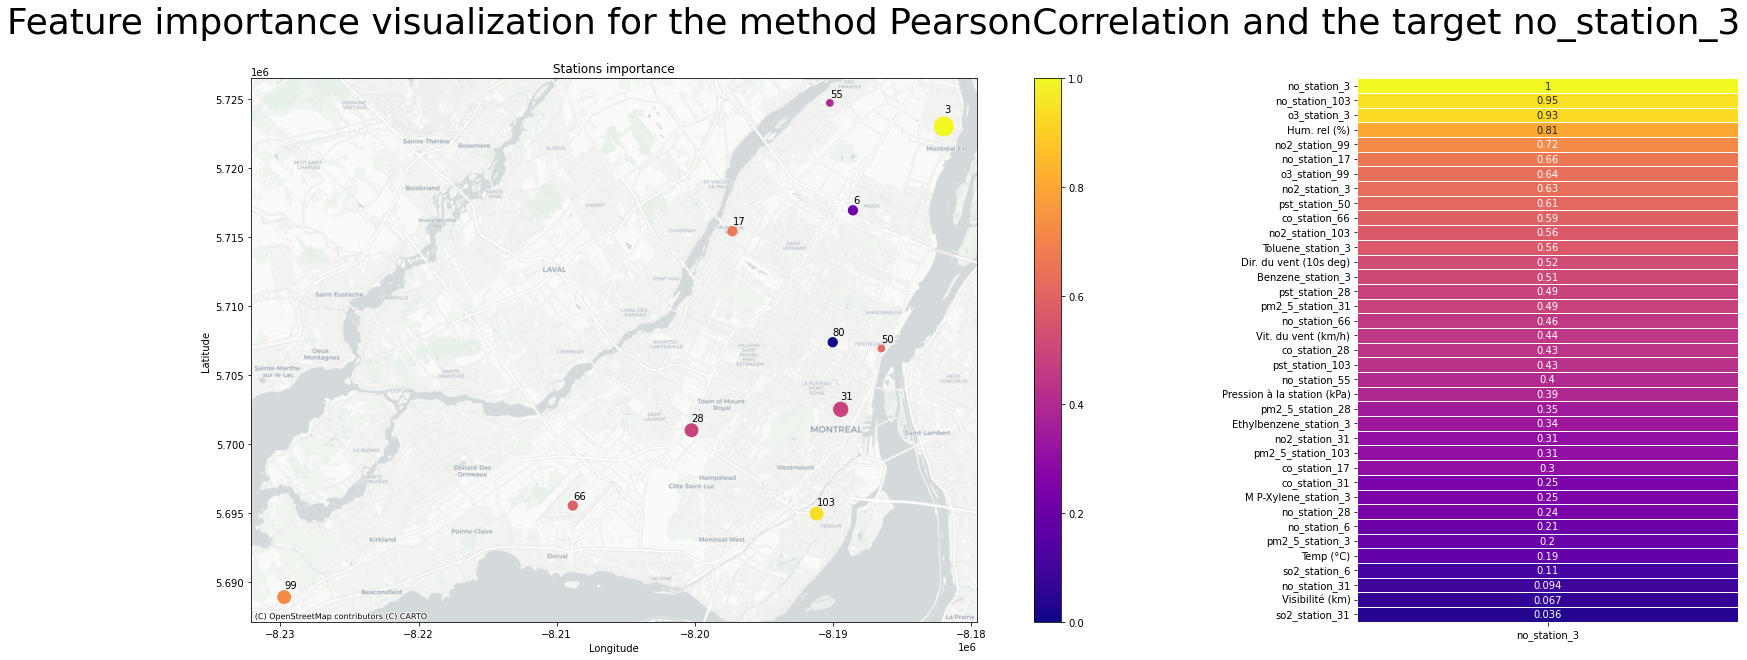

In [2]:
fs.plot(used_targets=['no_station_3'])

In [ ]:
fs.plot()

In [2]:
fs.explore(used_target='pm2_5_station_3', used_method='PearsonCorrelation')